In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import pickle
import networkx as nx
import ipywidgets
from ipywidgets import widgets

from run_simulation import invasion_main

# Running and Visualizing One Simulation

In [2]:
weeks_run = 15
simulation_df = invasion_main(weeks_run) # Change this to change the number of weeks
# print(type(simulation_df))
simulation_df

,County,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12,Week 13,Week 14,Week 15
0,Cook,0.1,0.186662,0.212198,3.614253e-01,0.192130,0.026916,0.365646,0.695112,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,DuPage,0.0,0.077565,0.196053,3.881808e-01,0.333772,0.564426,0.921852,1.000000,1.000000,1.000000,0.891100,1.000000,1.000000,1.000000,1.000000,1.000000
2,Kane,0.3,0.335655,0.386243,5.348569e-01,0.663181,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,Will,0.0,0.049161,0.074166,1.748304e-01,0.138796,0.081846,0.443101,0.957217,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,Winnebago,0.0,0.322716,0.302453,2.389328e-01,0.706664,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.935919,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Henderson,0.0,0.000000,0.000000,1.839430e-03,0.002525,0.000000,0.004577,0.009505,0.084870,0.213340,0.625251,0.794092,1.000000,1.000000,1.000000,1.000000
98,Calhoun,0.0,0.000000,0.000000,2.851007e-01,0.486202,0.607639,1.000000,1.000000,0.945229,0.934567,1.000000,1.000000,1.000000,0.959587,1.000000,1.000000
99,Schuyler,0.0,0.000000,0.000705,7.193787e-04,0.016423,0.033617,0.042126,0.119765,0.101042,0.533982,0.568662,1.000000,1.000000,0.856919,1.000000,1.000000
100,Gallatin,0.0,0.000006,0.000151,4.071317e-04,0.000920,0.002656,0.009822,0.021427,0.049942,0.076332,0.112549,0.255225,0.409269,0.273892,0.589650,1.000000


In [3]:
def make_visual_df(simulation_df):
    visual_df = simulation_df.T
    visual_df.columns = visual_df.iloc[0]
    visual_df = visual_df.drop(visual_df.index[0])
    return visual_df

visual_df = make_visual_df(simulation_df)
visual_df

County,Cook,DuPage,Kane,Will,Winnebago,Lake,McHenry,St. Clair,Kendall,Madison,...,Scott,Stark,Jasper,Hamilton,Pike,Henderson,Calhoun,Schuyler,Gallatin,Pope
Week 0,0.1,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Week 1,0.186662,0.077565,0.335655,0.049161,0.322716,0.0,0.051491,0.021598,0.0,0.508925,...,0.0,0.0,0.0,0.000526,0.0,0.0,0.0,0.0,0.000006,0.0
Week 2,0.212198,0.196053,0.386243,0.074166,0.302453,0.0,0.160776,0.0,0.10141,0.62954,...,0.032623,0.015534,0.0,0.001631,0.0,0.0,0.0,0.000705,0.000151,0.000016
Week 3,0.361425,0.388181,0.534857,0.17483,0.238933,0.091392,0.462383,0.041542,0.121448,0.63332,...,0.085077,0.004368,0.008548,0.001701,0.05943,0.001839,0.285101,0.000719,0.000407,0.000001
Week 4,0.19213,0.333772,0.663181,0.138796,0.706664,0.037386,0.689315,0.169768,0.199801,0.829934,...,0.032193,0.0,0.04639,0.006394,0.118115,0.002525,0.486202,0.016423,0.00092,0.000009
Week 5,0.026916,0.564426,1.0,0.081846,1.0,0.214885,0.721429,0.487176,0.232487,1.0,...,0.411543,0.091608,0.266162,0.006075,0.514714,0.0,0.607639,0.033617,0.002656,0.000614
Week 6,0.365646,0.921852,1.0,0.443101,1.0,0.889981,1.0,0.659473,0.479254,1.0,...,1.0,0.306569,0.369069,0.027284,1.0,0.004577,1.0,0.042126,0.009822,0.000619
Week 7,0.695112,1.0,1.0,0.957217,1.0,0.590655,1.0,0.59175,0.751681,1.0,...,1.0,0.355018,0.719756,0.027804,1.0,0.009505,1.0,0.119765,0.021427,0.003389
Week 8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.817266,0.995388,1.0,...,1.0,0.467803,1.0,0.032421,1.0,0.08487,0.945229,0.101042,0.049942,0.009871
Week 9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.725127,1.0,0.186904,1.0,0.21334,0.934567,0.533982,0.076332,0.012165


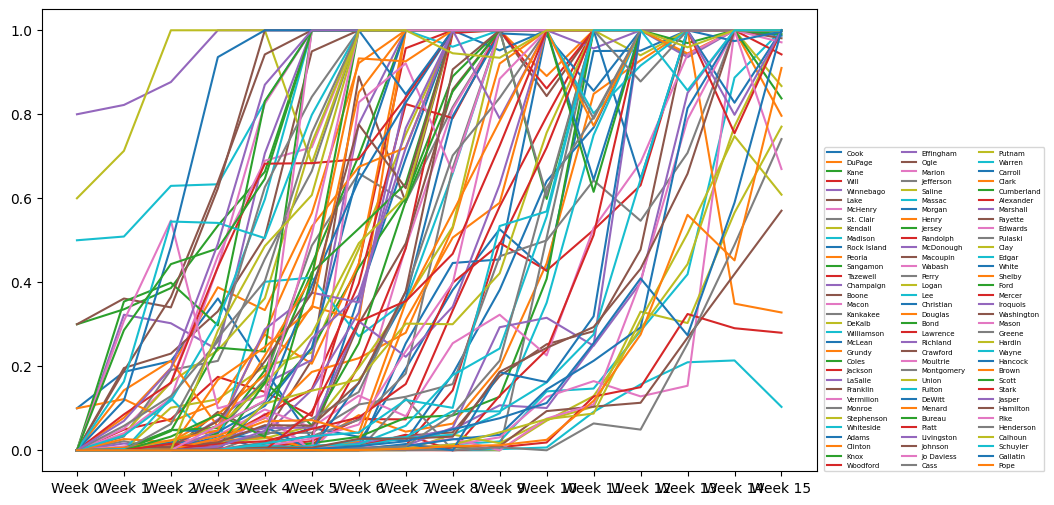

In [4]:
plt.figure(figsize=(10,6))
for county in visual_df.columns:
    plt.plot(visual_df.index, visual_df[county])
plt.legend(visual_df.columns, loc=(1.01, 0), fontsize=5, ncol=3)
plt.show()

In [5]:
path = 'data/location'
edges = pd.read_csv(f'{path}/county_edges.csv')

CG = pickle.load(open(f'{path}/IL_graph.dat', 'rb'))
handler = pickle.load(open(f'{path}/graph_handler_counties.dat', 'rb'))
highways = pickle.load(open(f'{path}/osmnx_highways.dat', 'rb'))

In [20]:
def make_network_heat(week):
    week = f'Week {week}'
#     min_value = simulation_df[week].min()
#     max_value = simulation_df[week].max()  # This makes the scale variable for each chart
    max_value = 1  # This keeps the scale constant 
    min_value = 0
    cmap = matplotlib.colormaps['YlOrRd']

    node_colors = {}
    for node in CG.nodes():
        value = simulation_df.loc[simulation_df['County'] == node.name, week].iloc[0]
        normalized_value = (value - min_value) / (max_value - min_value)
        node_colors[node.name] = cmap(normalized_value)
        
    labels = {node: handler[node.name].name for node in CG.nodes()}
    fig, ax = plt.subplots(figsize=(10, 15))
    node_positions = {node: [node.centroid.x, node.centroid.y] for node in CG.nodes()}
    nx.draw(CG, 
            pos=node_positions,
            ax=ax, 
            node_color=[node_colors.get(node.name, 'gray') for node in CG.nodes()],
            node_size=1500, )

    nx.draw_networkx_labels(CG, 
                            pos=node_positions, 
                            labels=labels,
                            font_size=6, 
                            ax=ax,
                           font_color='k')
    
    edge_colors = ['gray' if CG[src][tgt]['rel'] == 'interstate' else 'k' for src, tgt in CG.edges()]
    edge_widths = [5 if CG[src][tgt]['rel'] == 'interstate' else 1 for src, tgt in CG.edges()]
    nx.draw_networkx_edges(CG, pos=node_positions, edge_color=edge_colors, ax=ax, width=edge_widths)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_value, vmax=max_value))
    sm.set_array([])
    sub_ax = plt.axes([0.96, 0.55, 0.02, 0.3])
    plt.colorbar(sm, cax=sub_ax)
    plt.show()

In [21]:
widgets.interact(make_network_heat,
    week=widgets.IntSlider(min=0, max=len(simulation_df.columns)-2, step=1, layout=widgets.Layout(width='800px')),
)

interactive(children=(IntSlider(value=0, description='week', layout=Layout(width='800px'), max=15), Output()),…

<function __main__.make_network_heat(week)>

In [22]:
# This doesn't work very well for me since the page keeps re-centering

play = widgets.interact(make_network_heat, 
    week=widgets.Play( value=0,
                        min=0,
                        max=len(simulation_df.columns) - 2,
                        step=1,
                        interval=500,
                        disabled=False
                    ))

interactive(children=(Play(value=0, description='week', interval=500, max=15), Output()), _dom_classes=('widge…

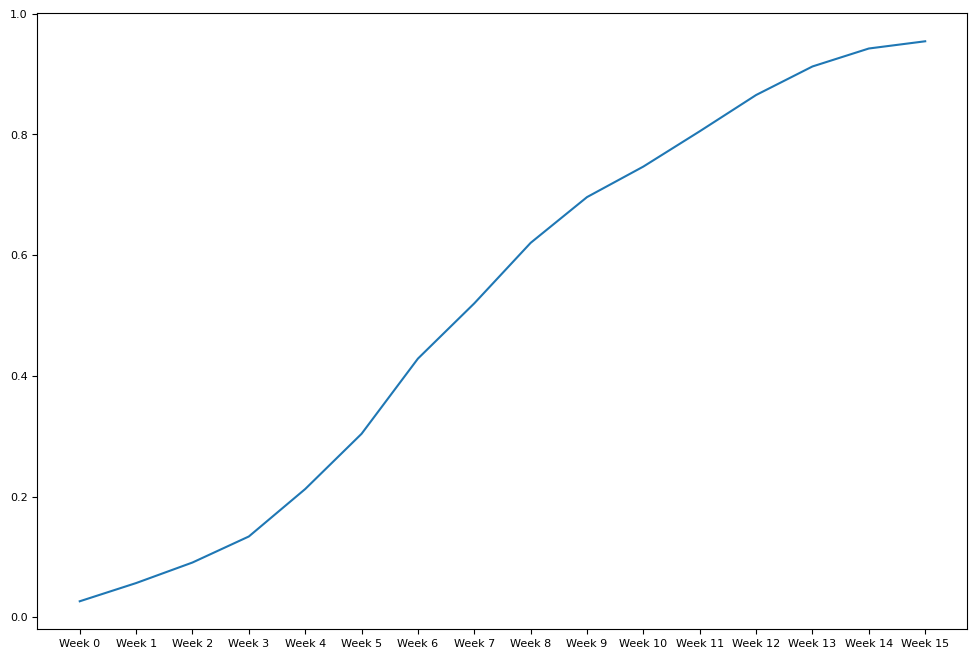

In [9]:
avg_df = visual_df.mean(axis=1)
plt.figure(figsize=(12,8))
plt.plot(avg_df.index, avg_df.iloc[0:, ])
plt.tick_params(labelsize=8)

# Repeating the Simulation and Plotting the Results

In [10]:
def make_average_graphs(df):
    vis_df = make_visual_df(df)
    avg_df = vis_df.mean(axis=1)
    plt.plot(avg_df.index, 
             avg_df.iloc[0:, ],
             linewidth=0.5)

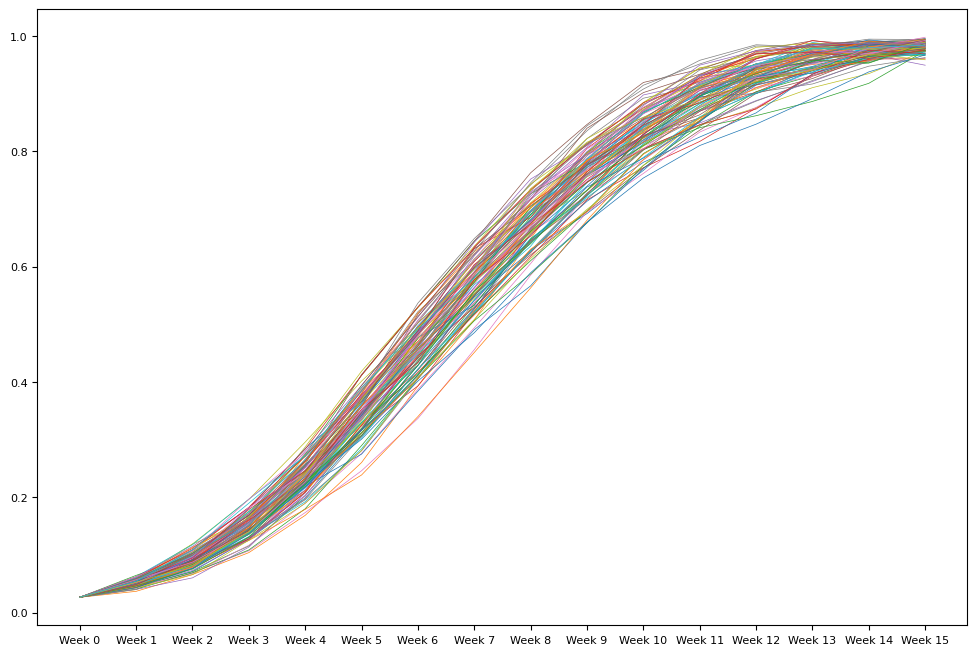

In [11]:
plt.figure(figsize=(12,8))
plt.tick_params(labelsize=8)

sims_run = 100  # RIP my RAM
sim_weeks = 15
for i in range(0, sims_run):
    df = invasion_main(sim_weeks)
    make_average_graphs(df)

plt.show()